In [139]:
import torch
import polars as pl 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using CUDA


In [140]:
data_df = pl.read_csv("data/google_stock_price_train_yfinance.csv")

data_df

Close,High,Low,Open,Volume,Date
f64,f64,f64,f64,f64,str
-1.604091,-1.602328,-1.608212,-1.60523,4.281968,"""2004-08-19"""
-1.582314,-1.588694,-1.595726,-1.602471,1.698872,"""2004-08-20"""
-1.579336,-1.576745,-1.572211,-1.575869,1.157011,"""2004-08-23"""
-1.591713,-1.58185,-1.587282,-1.574531,0.800902,"""2004-08-24"""
-1.588626,-1.591627,-1.58643,-1.591683,0.083813,"""2004-08-25"""
…,…,…,…,…,…
2.504705,2.514772,2.524529,2.542764,-0.809622,"""2016-10-26"""
2.484301,2.495744,2.497916,2.513484,-0.67987,"""2016-10-27"""
2.484411,2.561169,2.509456,2.553784,-0.500737,"""2016-10-28"""


In [141]:
import numpy as np

# RSI
window_rsi = 14
delta = data_df["Close"].diff().alias("rsi")

gain = delta.clip(lower_bound=0)
loss = -delta.clip(upper_bound=0)

avg_gain = gain.rolling_mean(window_size=window_rsi, min_periods=1)
avg_loss = loss.rolling_mean(window_size=window_rsi, min_periods=1)

rs = avg_gain / avg_loss

# MACD
short_span = 12
long_span = 26
signal_span = 9

macd = data_df["Close"].ewm_mean(span=short_span, adjust=False) - data_df[ "Close" ].ewm_mean(span=long_span, adjust=False)
signal = macd.ewm_mean(span=signal_span, adjust=False)

# Bollinger Bands
window_bollinger = 20
mid = data_df['Close'].rolling_mean(window_size=window_bollinger)
upper = mid + 2 * data_df['Close'].rolling_std(window_size=window_bollinger)
lower = mid - 2 * data_df['Close'].rolling_std(window_size=window_bollinger)

# 3 day price difference
returns = data_df['Close'].shift(-3).alias("3_day_price_diff") - data_df['Close']
print(returns)


data_df = data_df.with_columns(
    pl.col("Close").rolling_mean(20).alias("sma_20"),
    rs / (1 + rs).alias("rsi") / 100,
    macd.alias("MACD"),
    signal.alias("Signal"),
    upper.alias("Upper"),
    lower.alias("Lower"),
    pl.col('Date').str.to_datetime().dt.weekday().alias("Day") / 7,
    pl.col('Date').str.to_datetime().dt.month().alias("Month") / 12,
    returns
)

data_df

shape: (3_074,)
Series: '3_day_price_diff' [f64]
[
	0.012377
	-0.006312
	-0.004071
	0.003497
	-0.010902
	…
	-0.079698
	-0.064395
	null
	null
	null
]


Close,High,Low,Open,Volume,Date,sma_20,rsi,MACD,Signal,Upper,Lower,Day,Month,3_day_price_diff
f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
-1.604091,-1.602328,-1.608212,-1.60523,4.281968,"""2004-08-19""",null,null,0.0,0.0,null,null,0.571429,0.666667,0.012377
-1.582314,-1.588694,-1.595726,-1.602471,1.698872,"""2004-08-20""",null,NaN,0.001737,0.000347,null,null,0.714286,0.666667,-0.006312
-1.579336,-1.576745,-1.572211,-1.575869,1.157011,"""2004-08-23""",null,NaN,0.003316,0.000941,null,null,0.142857,0.666667,-0.004071
-1.591713,-1.58185,-1.587282,-1.574531,0.800902,"""2004-08-24""",null,0.006667,0.003528,0.001458,null,null,0.285714,0.666667,0.003497
-1.588626,-1.591627,-1.58643,-1.591683,0.083813,"""2004-08-25""",null,0.006923,0.0039,0.001947,null,null,0.428571,0.666667,-0.010902
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2.504705,2.514772,2.524529,2.542764,-0.809622,"""2016-10-26""",2.436987,0.006313,0.043734,0.033092,2.572851,2.301123,0.428571,0.833333,-0.079698
2.484301,2.495744,2.497916,2.513484,-0.67987,"""2016-10-27""",2.442565,0.006172,0.04046,0.034566,2.576469,2.308661,0.571429,0.833333,-0.064395
2.484411,2.561169,2.509456,2.553784,-0.500737,"""2016-10-28""",2.447524,0.005623,0.037442,0.035141,2.579825,2.315223,0.714286,0.833333,null


In [142]:
# split into train and validation
idx = int(len(data_df) * 0.8)
train_df = data_df.slice(0, idx)
val_df = data_df.slice(idx)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 2459
Validation size: 615


In [143]:
select = ["Close", "sma_20", "rsi", "MACD", "Signal", "Upper", "Lower", "Day", "Month"]
train_input = (
    torch.tensor(train_df.select(select).rows()[26:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(train_input.shape)

val_input = (
    torch.tensor(val_df.select(select).rows()[26:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(val_input.shape)  

torch.Size([1, 2433, 9])
torch.Size([1, 589, 9])


In [144]:
from torch.utils.data import Dataset, DataLoader


class StockDataset(Dataset):
    def __init__(self, input_tensor, window_steps=30, label_steps=1):
        self.input_tensor = input_tensor
        self.window_steps = window_steps
        self.label_step = label_steps

    def __len__(self):
        return self.input_tensor.shape[0] - self.window_steps - self.label_step + 1

    def __getitem__(self, idx):
        return self.input_tensor[idx : idx + self.window_steps], self.input_tensor[
            idx + self.window_steps : idx + self.window_steps + self.label_step
        ]


class BuyDataset(Dataset):
    def __init__(self, input_tensor, window_steps=30):
        self.input_tensor = input_tensor
        self.window_steps = window_steps

    def __len__(self):
        return self.input_tensor.shape[0] - self.window_steps

    def __getitem__(self, idx):
        return self.input_tensor[idx : idx + self.window_steps], self.input_tensor[
            idx + self.window_steps : idx + self.window_steps
        ]


predict_steps = 7
train_dataset = StockDataset(
    train_input.squeeze(), window_steps=30, label_steps=predict_steps
)
print(len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

val_dataset = StockDataset(
    val_input.squeeze(), window_steps=30, label_steps=predict_steps
)
print(len(val_dataset))


2397
torch.Size([30, 9])
torch.Size([7, 9])
553


In [145]:
from torch import nn
import random


class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            state = (h0, c0)
        out, h = self.rnn(x, state)
        out = self.fc(out)
        return out, h


class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size, hidden_size, num_layers=num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        out, h = self.rnn(x, h0)
        out = self.fc(out)
        return out, h


class LSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(LSTM2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            state = (h0, c0)
        _, h = self.rnn(x, state)
        out = self.fc(h)
        return out, h



# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
class SimpleSeq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(SimpleSeq2Seq, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # Encoder
        self.encoder = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )

        # Decoder
        self.decoder = nn.LSTM(
            output_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_input, decoder_input=None, target_length=None, state=None, teacher_forcing_ratio=0.5):
        """
        Forward method supports both training and inference:
        - Training: Pass `decoder_input` (teacher forcing).
        - Inference: Pass `target_length` to auto-regressively decode.

        Parameters:
        - encoder_input: Tensor of shape (batch_size, encoder_seq_len, input_size).
        - decoder_input: Tensor of shape (batch_size, decoder_seq_len, output_size) (for training).
        - target_length: Integer, length of the output sequence (for inference).
        """
        # Encoder forward pass
        if state is None:
            h0 = torch.zeros(self.num_layers, encoder_input.size(0), self.hidden_size).to(encoder_input.device)
            c0 = torch.zeros(self.num_layers, encoder_input.size(0), self.hidden_size).to(encoder_input.device)
            state = (h0, c0)

        _, encoder_hidden = self.encoder(encoder_input, state)

        # Prepare for decoder
        batch_size = encoder_input.size(0)
        decoder_outputs = []

        # Training (teacher forcing)
        if decoder_input is not None:
            # Use provided decoder input
            decoder_hidden = encoder_hidden
            decoder_input_step = decoder_input[:, 0].unsqueeze(1)  # First input
            out = None

            for t in range(decoder_input.size(1)):
                # Teacher forcing: Use the ground-truth target as the next input
                if out is None or random.random() < teacher_forcing_ratio:
                    decoder_input_step = decoder_input[:, t].unsqueeze(1)
                else:
                    decoder_input_step = out

                out, decoder_hidden = self.decoder(decoder_input_step, decoder_hidden)
                out = self.fc(out)
                decoder_outputs.append(out)

        # Inference (auto-regressive decoding)
        elif target_length is not None:
            decoder_hidden = encoder_hidden
            # use last input as the first decoder input
            decoder_input_step = encoder_input[:, -1].unsqueeze(1)

            for t in range(target_length):
                out, decoder_hidden = self.decoder(decoder_input_step, decoder_hidden)
                out = self.fc(out)
                decoder_outputs.append(out)
                decoder_input_step = out  # Use the last prediction as the next input

        # Concatenate outputs along the sequence length dimension
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

In [146]:
from utils.early_stopping import EarlyStopping
from utils.training2 import Trainer

rnn2 = SimpleSeq2Seq(train_input.shape[2], 100, train_input.shape[2], 2, dropout=0.5).to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(rnn2.parameters(), lr=0.00001, weight_decay=1e-5)
early_stop = EarlyStopping(patience=50, verbose=True, path="checkpoints/rnn2.pt")

trainer = Trainer(
    "test",
    rnn2,
    DataLoader(train_dataset, batch_size=16, shuffle=True),
    DataLoader(val_dataset, batch_size=16),
    optimizer,
    criterion,
    early_stop,
    teacher_forcing_phase=100
)

In [147]:
trainer.fit(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Validation loss decreased (inf --> 29.339950).  Saving model ...
Epoch [1/2000]  LR: 0.00001  T_Loss: 0.3828   V_Loss: 29.3399
Validation loss decreased (29.339950 --> 29.313471).  Saving model ...
Epoch [2/2000]  LR: 0.00001  T_Loss: 0.3668   V_Loss: 29.3135
EarlyStopping counter: 1 out of 50
Epoch [3/2000]  LR: 0.00001  T_Loss: 0.3448   V_Loss: 29.3768
EarlyStopping counter: 2 out of 50
Epoch [4/2000]  LR: 0.00001  T_Loss: 0.2870   V_Loss: 29.5625
EarlyStopping counter: 3 out of 50
Epoch [5/2000]  LR: 0.00001  T_Loss: 0.1764   V_Loss: 29.3811
Validation loss decreased (29.313471 --> 29.065604).  Saving model ...
Epoch [6/2000]  LR: 0.00001  T_Loss: 0.1506   V_Loss: 29.0656
Validation loss decreased (29.065604 --> 28.766894).  Saving model ...
Epoch [7/2000]  LR: 0.00001  T_Loss: 0.1419   V_Loss: 28.7669
Validation loss decreased (28.766894 --> 28.484397).  Saving model ...
Epoch [8/2000]  LR: 0.00001  T_Loss: 0.1371   V_Loss: 28.4844
Validation loss decreased (28.484397 --> 28.194857

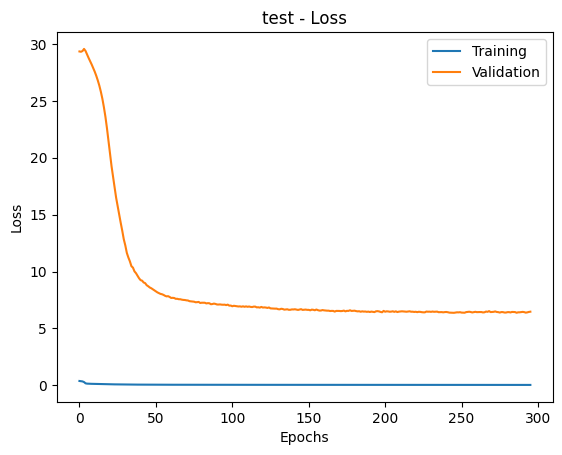

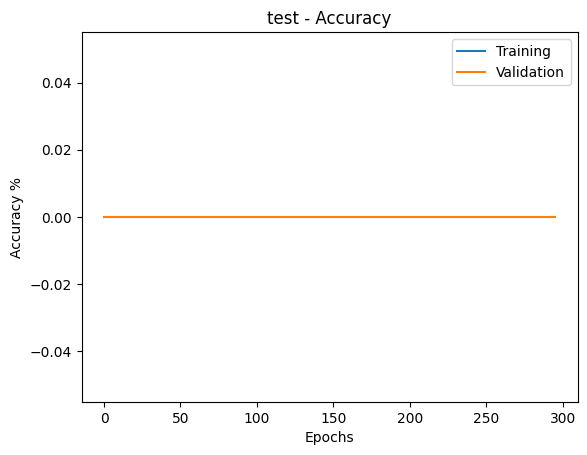

In [148]:
trainer.plot()

(553, 30, 9)
(553, 7, 9)
[(np.float64(0.0), np.float64(1.0), 0), (np.float64(0.16666666666666674), np.float64(0.8333333333333333), 0), (np.float64(0.33333333333333337), np.float64(0.6666666666666666), 0), (np.float64(0.5), np.float64(0.5), 0), (np.float64(0.6666666666666667), np.float64(0.3333333333333333), 0), (np.float64(0.8333333333333334), np.float64(0.16666666666666666), 0), (np.float64(1.0), np.float64(0.0), 0)]


/home/caleb/personal/uni/dlp/a3-rnn-stock-prediction/utils/training2.py:188: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/caleb/personal/uni/dlp/a3-rnn-stock-predicti

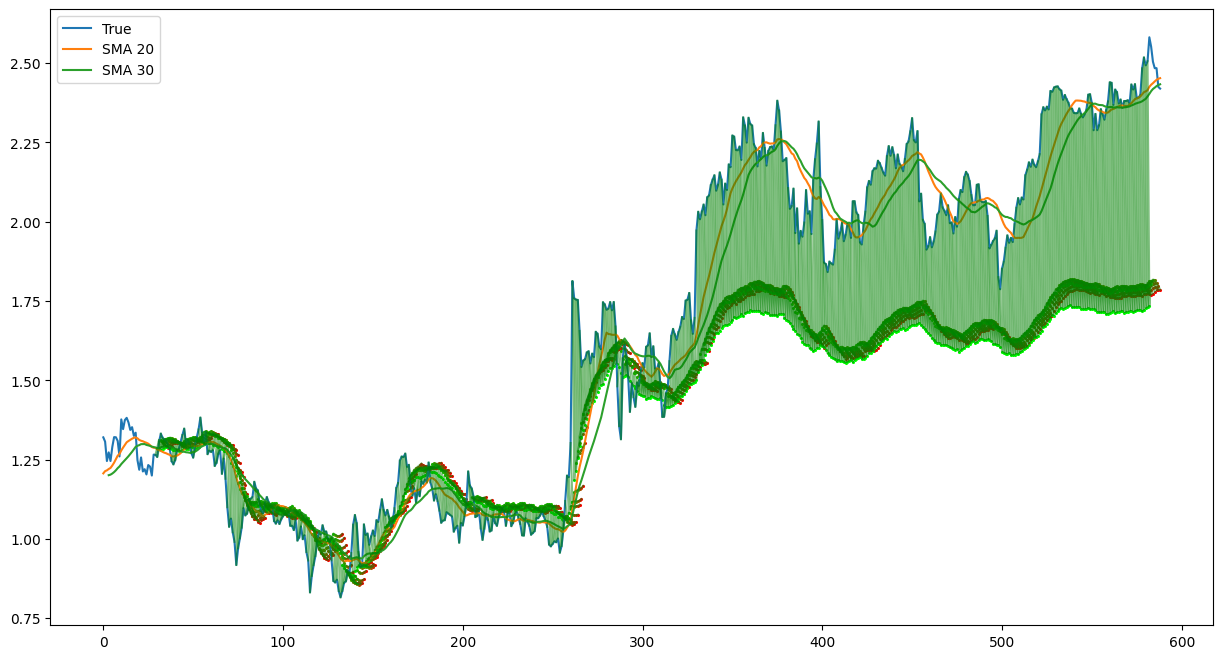

In [149]:
from utils.training import infer
import numpy as np

all_inputs, _, all_predictions = trainer.infer(DataLoader(val_dataset, batch_size=128))

print(all_inputs.shape)
# print(all_outputs.shape)
print(all_predictions.shape)


def create_gradient_colors(array_length):
    """
    Create a gradient array transitioning from green to yellow, orange, and red.

    Parameters:
        array_length (int): Length of the array for the gradient.

    Returns:
        list: Array of RGB color tuples.
    """
    if array_length < 1:
        raise ValueError("Array length must be at least 1.")

    # Create a linear gradient from 0 to 1
    gradient = np.linspace(0, 1, array_length)

    # Generate the colors: Green (0,1,0) -> Yellow (1,1,0) -> Orange (1,0.5,0) -> Red (1,0,0)
    colors = [
        (1 - g, g, 0)  # Interpolates Red and Green channels
        for g in gradient
    ]

    colors.reverse()
    return colors


# colours = [
#     'blue', 'yellow', 'orange', 'red'
# ]
colours = create_gradient_colors(predict_steps)
print(colours)


# plot the input closes as a line, plot the predictions as points. each prediction is 4 steps ahead, make each step a different color
plt.figure(figsize=(15, 8))
plt.plot(val_df["Close"][26:], label="True")
plt.plot(val_df["sma_20"][26:], label="SMA 20")
plt.plot(val_df["Close"].rolling_mean(30)[26:], label="SMA 30")

for i in range(0, all_predictions.shape[0]):
    for j, p in enumerate(all_predictions[i, :, 0]):
        plt.scatter([all_inputs.shape[1] + i + j], [p], c=colours[j], s=1.5)

    plt.plot(
        range(
            all_inputs.shape[1] + i - 1,
            all_inputs.shape[1] + i + all_predictions.shape[1],
        ),
        [val_df["Close"][26 + all_inputs.shape[1] + i - 1]] + all_predictions[i, :, 0].tolist(),
        c="green",
        alpha=0.5,
    )

plt.legend()
plt.show()

# Now create a plotly plot
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=val_df["Date"], y=val_df["Close"], mode="lines", name="True")
)

for i in range(0, all_predictions.shape[0]):
    for j, p in enumerate(all_predictions[i, :, 0]):
        fig.add_trace(
            go.Scatter(
                x=[val_df["Date"][all_inputs.shape[1] + i + j]],
                y=[p],
                mode="markers",
                marker=dict(color=colours[j]),
                name="Prediction",
            )
        )
    fig.add_trace(
        go.Scatter(
            x=val_df["Date"][
                all_inputs.shape[1] + i : all_inputs.shape[1]
                + i
                + all_predictions.shape[1]
            ],
            y=all_predictions[i, :, 0],
            mode="lines",
            line=dict(color="green", width=1),
            name="Prediction",
        )
    )

fig.show()
